In [1]:
from __future__ import print_function
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Concatenate
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import plot_model
from keras.models import Model
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import copy
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.


In [2]:
def data():
    import tensorflow as tf
    hdf5_path = 'dataset.hdf5'
    subtract_mean = True

    hdf5_file = h5py.File(hdf5_path, "r")

    if subtract_mean:
        mm = hdf5_file["train_mean"][...,0]
        mm = mm[np.newaxis, ...]

    data_num = hdf5_file["train_flow"].shape[0]
    
    num_classes = 2
    epochs = 30

    flow_rows, flow_cols = 298, 17

    x_train = hdf5_file["train_flow"][...,0]
    if subtract_mean:
        x_train -= mm

    y_train = hdf5_file["train_labels"][:,...]
    hdf5_file.close()

    hdf5_path = 'dataset-IoT.hdf5'
    hdf5_file = h5py.File(hdf5_path, "r")


    x_test = hdf5_file["IoT_flow"][...,0]
    if subtract_mean:
        x_test -= mm

    y_test = hdf5_file["labels"][:,...]

    hdf5_file.close()

    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
    d_class_weights = dict(enumerate(class_weights))

    input_shape = (x_train.shape[1], x_train.shape[2])
    
    
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return x_train, y_train, x_test, y_test

In [3]:
def create_model(x_train, y_train, x_test, y_test):
    size = {{choice([2,4,8,16,32,64])}}
    nb_filters = {{choice([32,64,128])}}
    num_classes = 2
    epochs=30
    activations={{choice(['relu', 'sigmoid', 'tanh'])}}
    maxlen=298
    dropout = {{uniform(0.1, 0.3)}}
    batch_size = {{choice([128,256])}}
    pool_size = {{choice([2,3])}}
    optimizers={{choice([keras.optimizers.Adadelta(lr=0.001),keras.optimizers.RMSprop(lr=0.001),keras.optimizers.Adam(lr=0.001)])}}
    layers = {{choice([1,2,3,4])}}
    model = Sequential()
    model.add(Conv1D(filters=nb_filters,kernel_size=size,input_shape=(input_shape),padding="valid",activation=activations,strides=1))
    for i in range(layers-1):
        model.add(Conv1D(filters=nb_filters,kernel_size=size,padding="valid",activation=activations,strides=1))
        
    model.add(MaxPooling1D(pool_size= pool_size))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer=optimizers, metrics=['accuracy'])
    model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_split=0.2, class_weight=class_weights, shuffle=True)
    score = model.evaluate(x_test, y_test, verbose=0)
    loss = score[0]
    return {'loss': loss, 'status': STATUS_OK, 'model': model} 
    
  

In [4]:
x_train, y_train, x_test, y_test = data()
best_run, best_model = optim.minimize(model=create_model, data=data, algo=tpe.suggest, max_evals=75, trials=Trials(), eval_space=True, notebook_name='1Dsequential')

print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    import h5py
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.utils import class_weight
except:
    pass

try:
    from sklearn.metrics import classification_report
except:
    pass

try:
    import keras
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, Dropout, Flatten, Input, Concatenate
except:
    pass

try:
    from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
except:
    pass

try:
    from keras.utils import plot_model
except:
    pass

try:
    from keras.models import Model
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    from PIL import Image
exce

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     34974
           1       0.85      0.46      0.60      7193

   micro avg       0.89      0.89      0.89     42167
   macro avg       0.87      0.72      0.77     42167
weighted avg       0.89      0.89      0.88     42167

[[34394   580]
 [ 3901  3292]]
0.9233618907035634


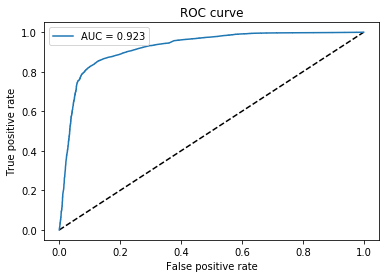

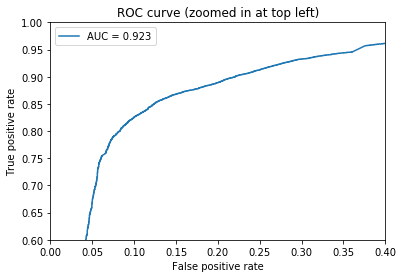

0.9773245190876975
0.766114715071076


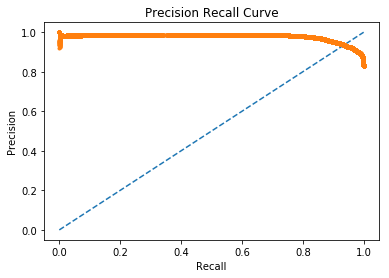

0.9187200972247892
0.766114715071076


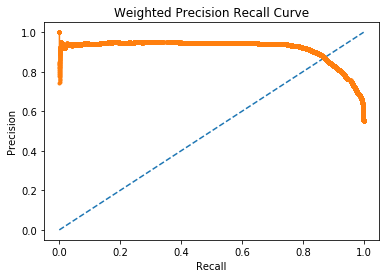

In [5]:
y_pred = best_model.predict(x_test)
yy_test = [np.argmax(i) for i in y_test]

yy_pred = [np.argmax(i) for i in y_pred]

print(classification_report(yy_test, yy_pred))     
  
new = np.vstack([yy_test,yy_pred])

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

print(confusion_matrix(yy_test, yy_pred))




y_pred_keras = best_model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(yy_test, y_pred[:,0],pos_label=0)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

f1 = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
f1.savefig("ROC-curve-cnn1Dseq.pdf", bbox_inches='tight')

f2 = plt.figure()
plt.xlim(0, 0.4)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()
f2.savefig("ROC-curve-zoomed-cnn1Dseq.pdf", bbox_inches='tight')

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

precision, recall, thresholds = precision_recall_curve(yy_test,  y_pred[:,0],pos_label=0)
# calculate F1 score
#f1 = f1_score(yy_test, y_pred)
# calculate precision-recall AUC
auc_score = auc(recall, precision)
print(auc_score)
# calculate average precision score
ap = average_precision_score(yy_test, y_pred[:,1])
print(ap)
#print('auc=%.3f ap=%.3f' % (auc, ap))
# plot no skill
f3 = plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the precision-recall curve for the model
plt.plot( recall, precision,marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

# show the plot
plt.show()
f3.savefig("precisionrecall-cnn1Dseq.pdf", bbox_inches='tight')
num_positive = float(np.count_nonzero(yy_test))
num_negative = float(len(yy_test) - num_positive)
pos_weight = num_negative / num_positive
weights = np.ones_like(yy_test)
weights[yy_test != np.float64(0)] = pos_weight


precision_weighted, recall_weighted, thresholds_weighted = precision_recall_curve(yy_test,  y_pred[:,0],pos_label=0,sample_weight=weights)
#calculate F1 score
#f1 = f1_score(yy_test, y_pred)
# calculate precision-recall AUC
auc_score = auc(recall_weighted, precision_weighted)
print(auc_score)
# calculate average precision score
ap = average_precision_score(yy_test, y_pred[:,1])
print(ap)
#print('auc=%.3f ap=%.3f' % (auc, ap))
# plot no skill
f4 = plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the weighted precision-recall curve for the model
plt.plot( recall_weighted, precision_weighted,marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Weighted Precision Recall Curve')
# show the plot
plt.show()
f4.savefig("weightedprecisionrecall-cnn1Dseq.pdf", bbox_inches='tight')
best_model.save('cnn1Dseq.h5')

In [6]:
d = {'False Positive Rate': fpr_keras, 'True Positive Rate': tpr_keras , 'Thresholds': thresholds_keras}

In [7]:
roc_CNN1Dseq = pd.DataFrame(data=d)

In [8]:
roc_CNN1Dseq.to_csv(path_or_buf ='rocCNN1Dseq.csv', index=False)

In [9]:
conf = confusion_matrix(yy_test, yy_pred)

In [10]:
conf1Dseq=pd.DataFrame(data=conf)

In [11]:
conf1Dseq.to_csv(path_or_buf='ConfusionCNN1Dseq.csv',index=False)

In [12]:
pd.DataFrame({"precision" : precision, "recall" :recall}).to_csv("precisionrecall-1dseq.csv", index=None)


In [13]:
pd.DataFrame({"precision" : precision_weighted, "recall" :recall_weighted}).to_csv("weightedprecisionrecall-1dseq.csv", index=None)
